# ECS784 Coursework 1
## Using SVC and K-Neighbors Algorithms to Distinguish Between Two Z Boson Decay Modes (75.8% accuracy)

## 1. The Data Analysis Problem
This Jupyter Notebook uses labelled Z Boson decay data originally taken from the CERN Open Data Portal which has been reduced to only electron-positron and muon-antimuon decays and uploaded to Kaggle.

The data set comes with 11 features and 1 label which we will predict. The label is the type of decay (Zee indicating that the Z boson has decayed to an electron and a positron or Zmumu indicating that the Z boson has decayed to a muon and an antimuon).

A table of the columns and a brief description of each one is given below. Most of the descriptions have been taken directly from the Kaggle data set.

Variable | Description
------|----------
Unnamed: 0 | An index labelling each event
Run | The run number of the event
Event | The event number
pt1 | The transverse momentum of the first lepton (in units of GeV), either a muon or an electron
eta1 | The pseudorapidity of the first lepton, either a muon or an electron
phi1 | The phi angle (in radians) of the first lepton, either a muon or an electron
Q1 | The charge of the first lepton, either a muon or an electron
pt2 | The transverse momentum of the second lepton (in units of GeV), either a muon or an electron
eta2 | The pseudorapidity of the second lepton, either a muon or an electron
phi2 | The phi angle (in radians) of the second lepton, either a muon or an electron
Q2 | The charge of the second lepton, either a muon or an electron

The Kaggle data set can be found here:
https://www.kaggle.com/datasets/omidbaghchehsaraei/identification-of-two-modes-of-z-boson?datasetId=2903822

## 2. Exploring the Data Using pandas

### 2.1 Importing the necessary modules and defining a dictionary of column descriptions

In [27]:
# Importing relevant data sets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns  

%matplotlib inline

In [28]:
# Defining a dictionary which contains the column abbreviations to proper names
# mappings

column_name_abbreviations = {
    "pt1" : "Transverse Momentum of Lepton 1",
    "pt2" : "Transverse Momentum of Lepton 2",
    "eta1" : "Pseudorapidity of Lepton 1",
    "eta2" : "Pseudorapidity of Lepton 2",
    "phi1" : "Azimuthal Angle of Lepton 1 (radians)",
    "phi2" : "Azimuthal Angle of Lepton 2 (radians)",
    "Q1" : "Charge of Lepton 1",
    "Q2" : "Charge of Lepton 2",
    "class" : "Class of Lepton",
    "class_number" : "Mapping of class to a number (0 for Zee, 1 for Zmumu)"
    }

### 2.2 Reading the data, dropping certain columns and rows and converting categorical variables to integer variables
We remove rows such as the unnamed indexing row, the run and event numbers which can not bear any relation to the physics of the decay. 

As can be seen in the small portion of df shown below, the original data set contained many decays where two leptons with identical charges were observed. Since the Z boson is neutral with respect to electrical charge, it cannot possibly decay into two particles with like charges. This observation motivated the creation of a second data set, df2, with all such data-points removed.

In [29]:
# Loading data
df = pd.read_csv("Z_boson.csv")

# We can remove the run event and unnamed columns as they will be unrelated 
# to the physics of the event. This leaves us with 8 features.
df = df.drop(columns=["Unnamed: 0", "Run", "Event"])

# We now want to create a mapping between class and a number. 
# We choose Zee corresponding to 0 and Zmumu corresponding to 1
templl = []
for index, row in df.iterrows():
    if row["class"] == "Zee":
        templl.append(0)
    elif row["class"] == "Zmumu":
        templl.append(1)
    else:
        templl.append(None)

# Counting events where neither Zee nor Zmumu were chosen (i.e counting Nones)
# for peace of mind. There should be 0 occurrences.
def countNones(ll):
    counter = 0
    for entry in ll:
        if entry == None:
            counter += 1
    return counter

# Calling our function we can see there are indeed 0 occurrences.
countNones(templl)

# We now add the class_number to the DataFrame
df["class_number"] = templl

df = df.drop(columns=["class"])

# Briefly inspecting the class and class_number columns we can see we have
# successfully mapped class to a number and removed the class attribute as intended.
df

,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,class_number
0,42.9130,-1.3248,-3.0057,-1,42.2897,-0.6624,0.3485,1,1
1,39.8744,-0.0057,-0.7744,-1,36.3997,1.3710,2.2952,1,0
2,72.9296,-0.4162,0.9198,1,39.5410,-0.2680,-1.4629,1,0
3,33.4436,0.3063,-1.6034,1,27.2395,-1.6182,1.5315,-1,0
4,43.9826,0.4276,-0.3876,-1,29.7856,-0.3080,2.8965,1,1
...,...,...,...,...,...,...,...,...,...
19995,39.1588,0.0434,2.8371,-1,48.0734,-0.8716,-0.7647,1,1
19996,38.4240,-1.3922,-1.9531,-1,30.3328,-0.9045,0.8390,1,1
19997,35.2640,-2.2673,-0.3794,-1,37.2768,-1.8151,2.9126,-1,0
19998,38.9526,-2.2869,1.4960,-1,48.5297,-2.1804,-1.0817,1,0


In [30]:
# Physically, one would expect Q1 = -Q2 as the Z boson is neutral 
# with respect to electrical charge (charge conservation).
# We now define and call a function which scans through the DataFrame 
# counting the number of events which violate this expectation.
def countChargeConservationViolations(df):
    counter = 0
    for index, row in df.iterrows():
        if row["Q1"] == row["Q2"]:
            counter+=1
    return counter

print("Number of like charge decays in df: " + str(countChargeConservationViolations(df)))

# As we can see there are 2745 events where the charge of particle 1 
# is not opposite to the charge of particle 2.This represents 13.725% of 
# the data set. We can conclude there may have been an error with these 
# data-points. We will bear this in mind and see if our results improve 
# when removing these data-points.

# Copying the data set and removing data-points with non opposite charges 
# in a separate DataFrame df2.
df2 = df.copy()
for index, row in df2.iterrows():
    if row["Q1"] == row["Q2"]:
        df2 = df2.drop(index=[index])

# calling our counting function again we can see the charge violating 
# events are no longer present in df2.
print("Number of like charge decays in df2: " + str(countChargeConservationViolations(df2)))

Number of like charge decays in df: 2745
Number of like charge decays in df2: 0


### 2.3 Distributions of categorical values
Checking the relative levels of Zee to Zmumu decays. Keep in mind a class_number of 0 corresponds to a class of Zee and a class_number of 1 corresponds to a class of Zmumu.

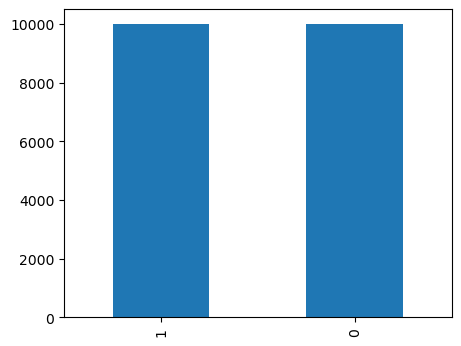

In [31]:
# PLotting counts using pandas in-built functions (which calls matplotlib functions)
df['class_number'].value_counts().plot.bar(figsize=(5, 4)) 
plt.show()

### 2.4 Distributions of continuous variables
Checking how the continuous data is distributed. We will want to normalise the data so that it is distributed over roughly the same scale for each feature later.

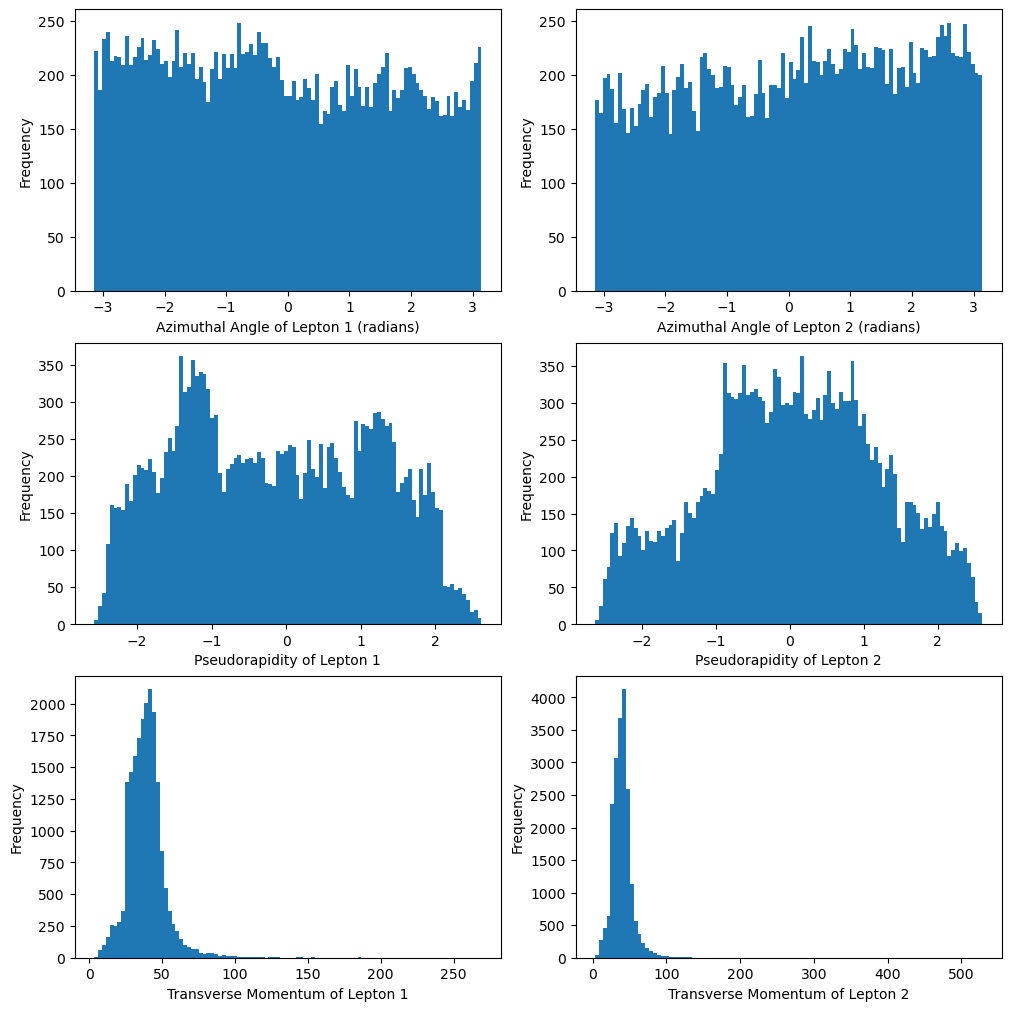

In [32]:
# Creating plots to show the distributions of the data with respect to
# different features.
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,10), 
                         constrained_layout=True, sharey=False)

def build_hist(df, col, posx, posy):
    df[col].plot(kind="hist", bins = 100, ax = axes[posx,posy])
    axes[posx,posy].set_xlabel(column_name_abbreviations[col])
    
build_hist(df, "phi1", 0, 0)
build_hist(df, "phi2", 0, 1)
build_hist(df, "eta1", 1, 0)
build_hist(df, "eta2", 1, 1)
build_hist(df, "pt1", 2, 0)
build_hist(df, "pt2", 2, 1)

plt.show()

### 2.5 Bivariate Analysis - checking if categorical variable seems predictive of decay class
The only categorical features present are Q1 and Q2. Due to the symmetry of the decay, it is unlikely for Q1 or Q2 to be predictive of the class of the decay. Checking this hypothesis involves some additional plotting.

Counts for Q1 vs Loan_Status are:
class_number     0     1
Q1                      
-1            4902  5156
 1            5098  4844

Normalised counts for Self_Employed vs Loan_Status are:
class_number         0         1
Q1                              
-1            0.487373  0.512627
 1            0.512774  0.487226

 Now for Q2: 

Counts for Q1 vs Loan_Status are:
class_number     0     1
Q2                      
-1            5037  4808
 1            4963  5192

Normalised counts for Self_Employed vs Loan_Status are:
class_number         0         1
Q1                              
-1            0.487373  0.512627
 1            0.512774  0.487226


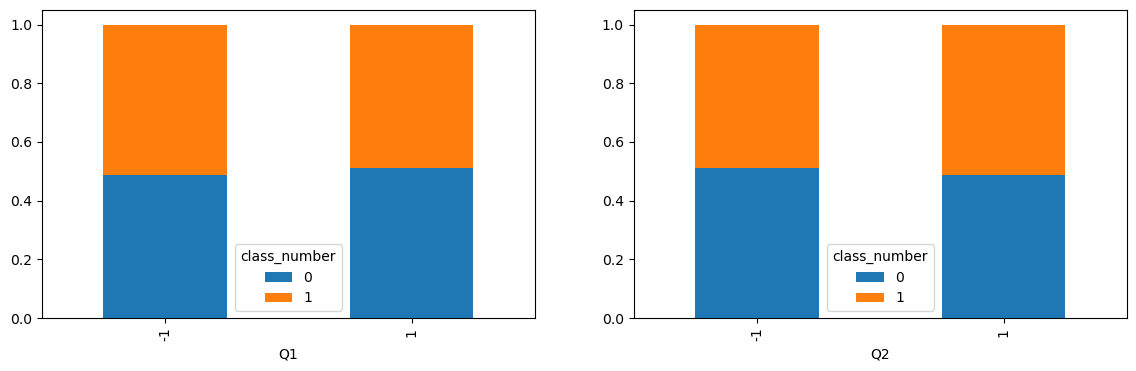

In [33]:
# Creating a crosstab, which counts the number of data-points in each value of Q1 corresponding
# to each value of the class_number.
charge1=pd.crosstab(df['Q1'],df['class_number'])
print('Counts for Q1 vs Loan_Status are:\n{}'.format(charge1))

# Normalising

charge1 = charge1.div(charge1.sum(1).astype(float), axis=0)
print('\nNormalised counts for Self_Employed vs Loan_Status are:\n{}'.format(charge1))

print("\n Now for Q2: \n")

# Repeating for Q2

charge2=pd.crosstab(df['Q2'],df['class_number'])
print('Counts for Q1 vs Loan_Status are:\n{}'.format(charge2))

# Normalising

charge2 = charge2.div(charge2.sum(1).astype(float), axis=0)
print('\nNormalised counts for Self_Employed vs Loan_Status are:\n{}'.format(charge1))

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
charge1.plot(kind="bar",stacked=True, ax=axes[0])
charge2.plot(kind="bar",stacked=True, ax=axes[1])
plt.show()


Inspecting the plots, Q1 and Q2 do not look particularly predictive as expected.

### 2.6 Bivariate Analysis - checking if a continuous variable seems predictive of the decay class

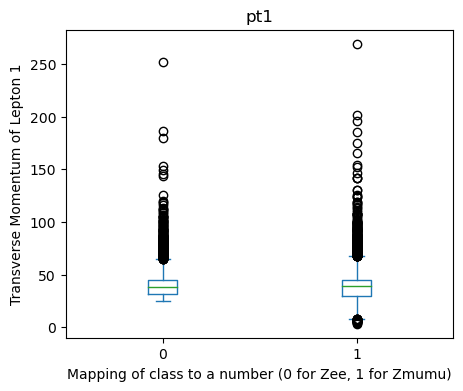

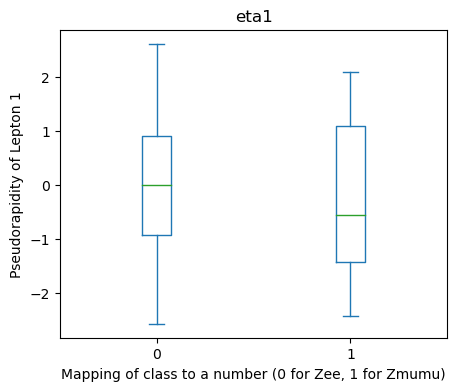

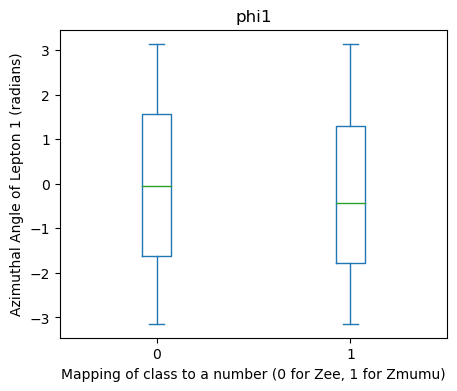

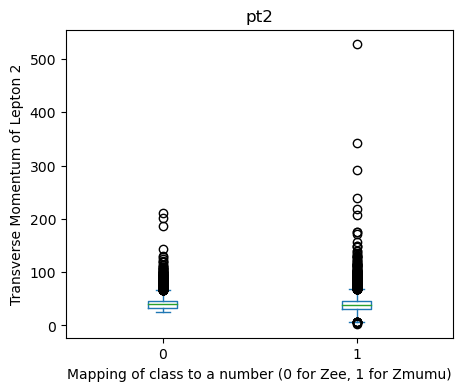

In [34]:
def build_bivariate_box(col):
    df.plot(column=col, by='class_number', kind='box', subplots=False, 
            ylabel=column_name_abbreviations[col], figsize=(5, 4))
    plt.xlabel(column_name_abbreviations['class_number'],)
    plt.show()

build_bivariate_box("pt1")
build_bivariate_box("eta1")
build_bivariate_box("phi1")
build_bivariate_box("pt2")

## 3. Preprocessing data using pandas
### 3.1 Missing value imputation

In [9]:
# count the null/NaN/missing values for each variable
df.isnull().sum()

pt1             0
eta1            0
phi1            0
Q1              0
pt2             0
eta2            0
phi2            0
Q2              0
class_number    0
dtype: int64

There are no null values in any of the features or in the label, so no missing value imputation is necessary.

### 3.2 Creating composite variables
Physically we expect the disparity between the total kinetic energy of the decay particles and the total initial beam energy to be larger for the Zmumu mode compared to the Zee mode.

The total initial Z boson energy is related to the Z boson momentum, which due to momentum conservation is equal to the vector sum of the leptons' momentums.

The formula for the calculation of the momentum in the z direction (pz) comes from "Introduction to High-Energy Heavy-Ion Collisions" by Cheuk-Yin Wong, pg 24.

The formulas for the momentums in the x and y directions (px and py) directly follow from the definition of the transverse momentum and the phi angle.

In [10]:
# Defining a function which calculates the total momentum of each particle and the
# initial momentum of the decaying Z boson and adds the columns to the tables
def addMomentumColumns(df):
    newdf = df.copy()
    p1_list = []
    p2_list = []
    ptot_list = []

    for index, row in df.iterrows():
        # Extracting the transverse momentum, pseudorapidity and phi angle of each particle
        # into variables
        pt1 = row["pt1"]
        pt2 = row["pt2"]
        
        eta1 = row["eta1"]
        eta2 = row["eta2"]
        
        phi1 = row["phi1"]
        phi2 = row["phi2"]
        
        # Using the transverse momentum and the pseudorapidity to find the momentum components
        # of each lepton.
        p1x = pt1*np.cos(phi1)
        p2x = pt2*np.cos(phi2)
        
        p1y = pt1*np.sin(phi1)
        p2y = pt2*np.sin(phi2)
        
        p1z = pt1*np.sinh(eta1)
        p2z = pt2*np.sinh(eta2)
        
        # Combining to find the total momentum of each particle
        p1 = (p1x**2 + p1y**2 + p1z**2)**0.5
        p2 = (p2x**2 + p2y**2 + p2z**2)**0.5
        
        # Combining to find the total momentum of the system (equal to the momentum of the
        # original Z boson)
        ptot = ((p1x + p2x)**2 + (p1y + p2y)**2 + (p1z + p2z)**2)**0.5
        
        # Adding each value to our lists.
        p1_list.append(p1)
        p2_list.append(p2)
        ptot_list.append(ptot)
        
    # Adding our lists to our DataFrame
    newdf["p1"] = p1_list
    newdf["p2"] = p2_list
    newdf["ptot"] = ptot_list
    
    return newdf

    
# Calling our function on both of our DataFrames.
df = addMomentumColumns(df)
df2 = addMomentumColumns(df2)

# Adding our new p1 and p2 columns to the abbreviations dictionary
column_name_abbreviations["p1"] = "Total Momentum of Particle 1"
column_name_abbreviations["p2"] = "Total Momentum of Particle 2"
column_name_abbreviations["ptot"] = "Total Momentum of System"

### 3.3 Checking data distributions for new composite variables

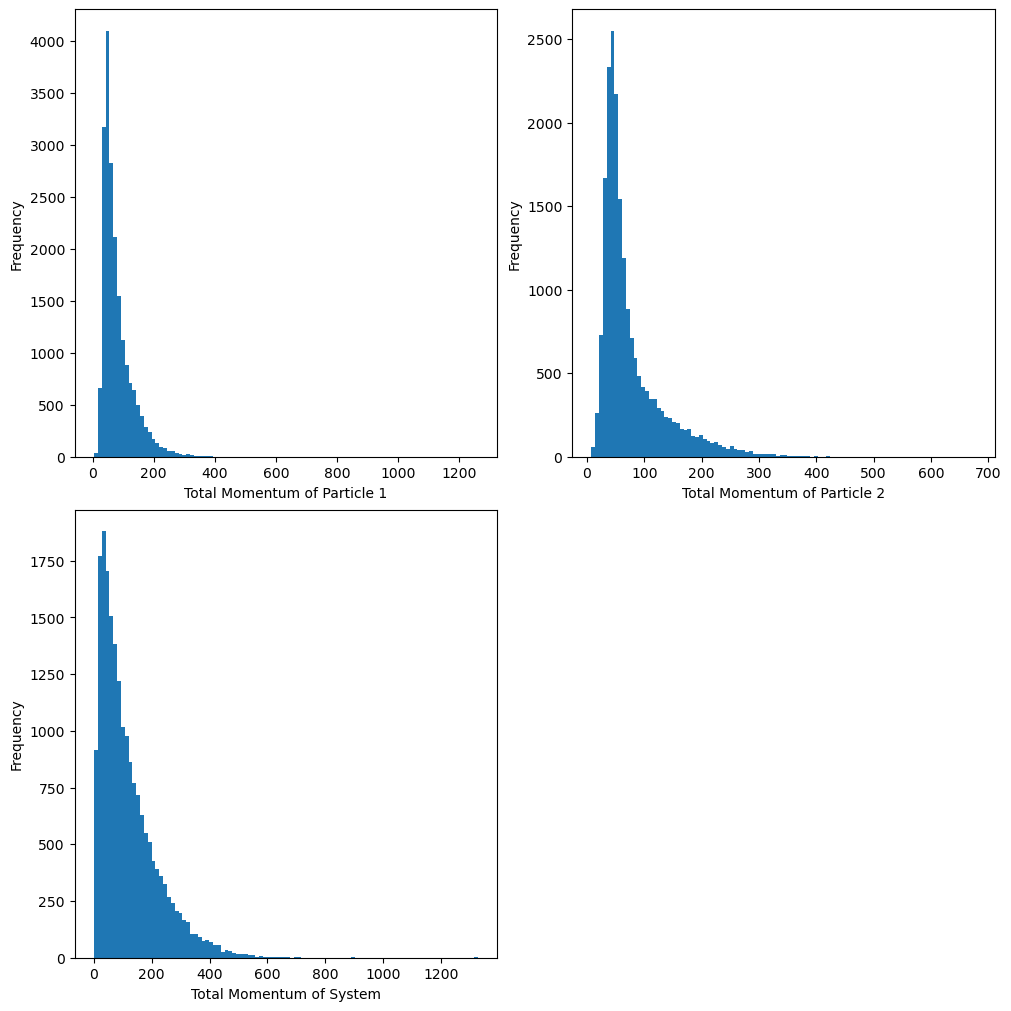

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10), 
                         constrained_layout=True, sharey=False)
    
build_hist(df, "p1", 0, 0)
build_hist(df, "p2", 0, 1)
build_hist(df, "ptot", 1, 0)

# Deleting the extra plot
fig.delaxes(axes[1][1])

plt.show()

### 3.4 Adjusting distributions of continuous variables
Inspection of the momentum related distributions reveals that the distributions are not normally distributed. This motivates the rescaling of the data using a log-based approach.

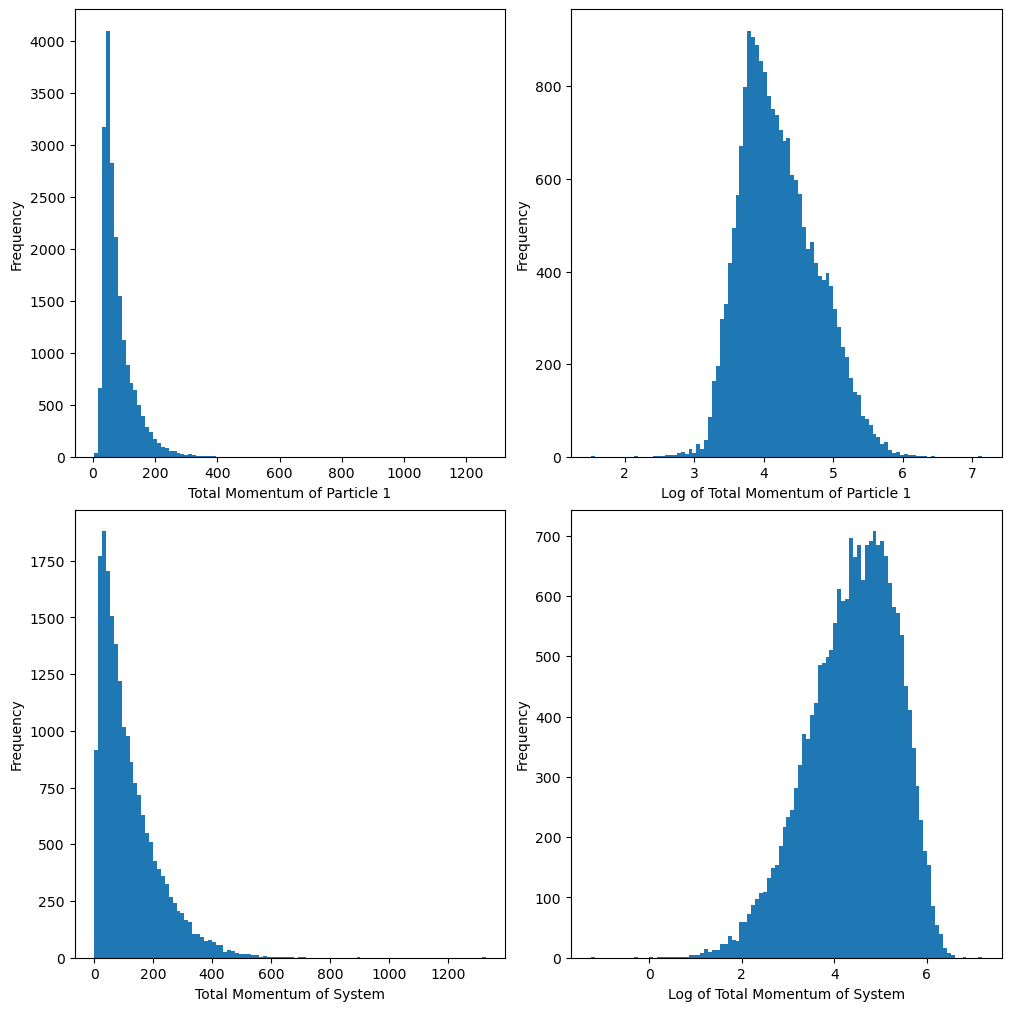

In [12]:
# Specifying the columns we are going to remap with a log
cols_for_logging = ["pt1","pt2","p1","p2","ptot"]

def log_scale_column(col, df):
    # Creating a column with "Log" appended to the end of the column name
    df[col + "Log"] = np.log(df[col])
    # Adding relevent descriptions to the dictionary
    column_name_abbreviations[col + "Log"] = "Log of " + column_name_abbreviations[col]

# Calling our function on all the columns in the cols_for_logging list, editing both DataFrames
for col in cols_for_logging:
    log_scale_column(col,df)
    log_scale_column(col,df2)

    
# Plotting two before and after examples of data pre-logging and post-logging
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10), 
                         constrained_layout=True, sharey=False)
    
build_hist(df, "p1", 0, 0)
build_hist(df, "p1Log", 0, 1)
build_hist(df, "ptot", 1, 0)
build_hist(df, "ptotLog", 1, 1)

plt.show()

After mapping using logs, the data appears to be distributes across roughly the same scales, and so it appears that linearly rescaling features to the same scales may not be necessary.

## 4. Feature Selection
### 4.1 Inspecting correlations between each pair of variables using pandas

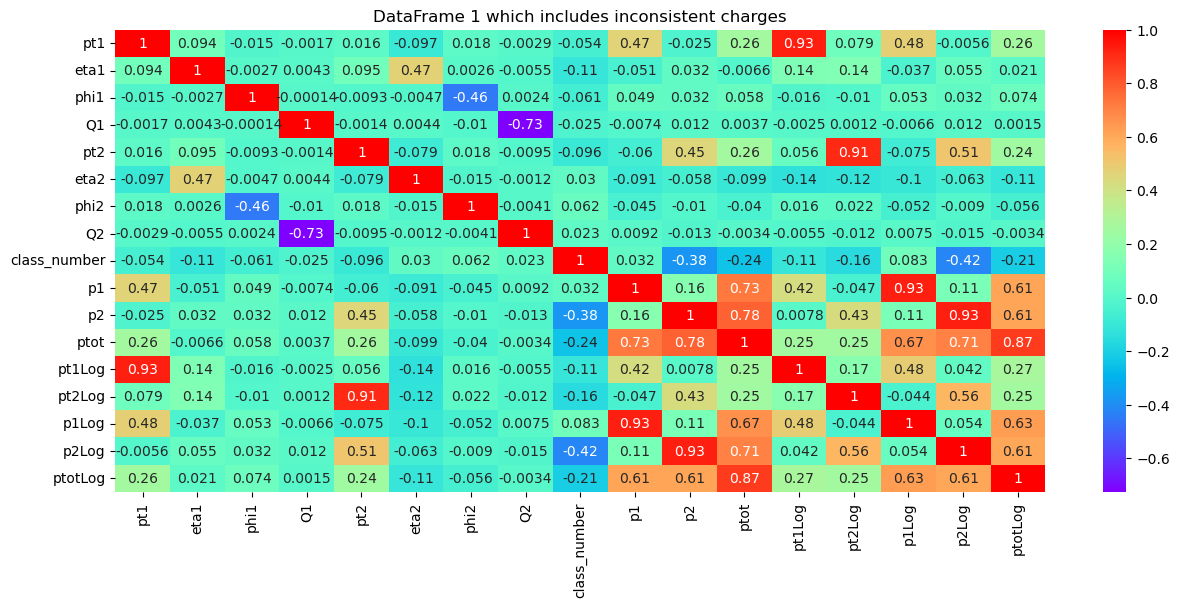

In [13]:
corr = df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="rainbow")
plt.title("DataFrame 1 which includes inconsistent charges")
plt.show()

As might be expected, the log values of the momentum based features are highly correlated with their un-logged counter parts, and mostly have similar correlations to other features. This motivates the removal of the original un-logged features.

Inspection reveals phi1 and phi2 are strongly correlated with each other, but weakly correlated to other features. This is also the case with Q1 and Q2. Physically this makes sense due to the physical rotational and general symmetry of the situation/ decay. This motivates the removal of the four variables.

The same could be true for eta1 and eta2, however the correlations with other features are slightly stronger than the previously discussed variables, so they will be kept.

In [14]:
# Dropping the features discussed
cols = ['pt1', 'pt2', 'p1', 'p2', 'ptot', 'phi1', 'phi2', 'Q1', 'Q2']

try:
    df = df.drop(columns=cols,axis=1)
except KeyError:
    print("Columns have likely already been removed for df")
    
try:
    df2 = df2.drop(columns=cols,axis=1)
except KeyError:
    print("Columns have likely already been removed for df2")

## 5. Prediction and Evaluation using scikit-learn
### 5.1 Importing relevant modules and defining the functions we will use to train our models

In [15]:
# Importing relevant modules
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
    recall_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
def train_and_evaluate(algorithm, hyperparams, X, y):
    """
        Train and evaluate a classification model on training data
        and produce accuracy metrics for a separate test set.
    """
    model = algorithm(**hyperparams)

    print('\nResults from algorithm {}:'.format(model))

    # Split data into train and test - we will use test for the final accuracy metrics
    # and not use it to train the model. This is good practice, particularly when you are
    # using cross-validation to select model parameters ... that way, the characteristics
    # of the test data don't leak into the model training
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Cross-validation accuracy gives an indication of variation in accuracy and a better
    # estimate for overall accuracy than just a single estimate. The mean cross-validation
    # accuracy is therefore a better guide when selecting model parameters or comparing models
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print('Mean cross-validation accuracy is {:.3f} with SD {:.3f}'
          .format(np.mean(scores), np.std(scores)))

    # Fit model using all of the reserved training data ... look at training accuracy 
    # which we generally expect to be better than test accuracy

    learnt_model = model.fit(X_train, y_train)
    print('\nAccuracy on training data is {:.3f}\n'.format(model.score(X_train, y_train)))
    
    # User predict() to predict target values from test feature variables, and then
    # use functions to compute evaluation metrics relevant to binary outcome variable
    
    # since we have not used data with positives and negatives the f1 score recall and precision
    # do not make sense here so we only print the accuracy on the test data

    y_pred = model.predict(X_test)
    print('Accuracy on test data is {:.3f}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
    
    # Draw out a confusion matrix
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize=(2, 2))
    ax = sns.heatmap(cm,annot=True, xticklabels=['Zee', 'Zmumu'], cbar=False, 
                     yticklabels=['Zee', 'Zmumu'], square=True,
                     linewidths=8.0) # plots the confusion matrix
    ax.set_xlabel('Predicted Decay Mode')
    ax.set_ylabel('Actual Decay Mode')
    plt.show()
    
    return learnt_model

### 5.2 Support Vector Classification (SVC)
We are working on a classification problem so one natural machine learning method would be SVC.


Results from algorithm SVC():
Mean cross-validation accuracy is 0.725 with SD 0.006

Accuracy on training data is 0.727

Accuracy on test data is 0.732


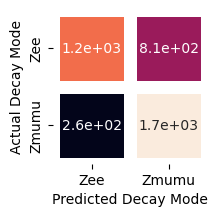


Results from algorithm SVC():
Mean cross-validation accuracy is 0.742 with SD 0.008

Accuracy on training data is 0.743

Accuracy on test data is 0.739


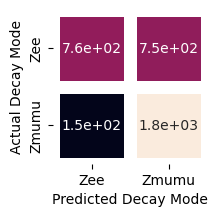

In [17]:
# Calling our train and evaluate function on both DataFrames
X1 = df.drop(["class_number"], axis=1)
y1 = df["class_number"]

_ = train_and_evaluate(SVC, {}, X1, y1)

X2 = df2.drop(["class_number"], axis=1)
y2 = df2["class_number"]

_ = train_and_evaluate(SVC, {}, X2, y2)

### 5.3 K-Neighbors classifier
Another natural classifier method is K-Nearest Neighbors.


Results from algorithm KNeighborsClassifier():
Mean cross-validation accuracy is 0.736 with SD 0.006

Accuracy on training data is 0.826

Accuracy on test data is 0.749


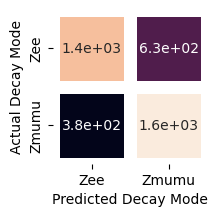


Results from algorithm KNeighborsClassifier():
Mean cross-validation accuracy is 0.743 with SD 0.009

Accuracy on training data is 0.823

Accuracy on test data is 0.727


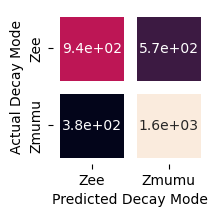

In [ ]:
# Calling our train and evaluate function on both DataFrames
X1 = df.drop(["class_number"], axis=1)
y1 = df["class_number"]

_ = train_and_evaluate(KNeighborsClassifier, {}, X1, y1)

X2 = df2.drop(["class_number"], axis=1)
y2 = df2["class_number"]

_ = train_and_evaluate(KNeighborsClassifier, {}, X2, y2)

## 6. Select best hyperparameter values using cross-validation

Selecting best hyperparameters using cross-validation, and then reporting accuracy using a test data set which wasn't used to select the hyperparameter.

For the SVC classifier, the regularisation parameter will be investigated and for the K-Neighbors Classifier, the number of neighbours considered will be investigated. All other hyperparameters will be left as default.

In [ ]:
# Defining a train_model function
def train_model(algorithm, hyperparams, X, y):
    """
        Use cross-validation to determine model accuracy for a 
        specified algorithm, hyperparameters, features and target
        variables.
        
        :param Scikit-Learn class algorithm: name of constructor for algorithm
        :param dict hyperparameters: hyperparameters passed to constructor- keys must 
                                     be parameters allowed for constructor
        :param array-like X: values of feature variables
        :param vector-like y: values of target variables
        
        :returns tuple: mean accuracy across all CV folds, and trained model
    """
    
    # Instantiate the specified model using the specified hyperparameter values

    model = algorithm(**hyperparams)

    # Perform cross-validation over the data to get a good view of accuracy
    
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # Fit model to supplied data

    learnt_model = model.fit(X, y)

    # Return mean accuracy over all CV folds

    return (np.mean(scores), learnt_model)

### 6.1 Selecting regularisation for the SVC model
We first find the appropriate order of magnitude for the regularisation parameter (C), then we check the different values on that order of magnitude.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

0.1  0.7129375
1  0.7250624999999999
10  0.7323125000000001
100  0.7408125


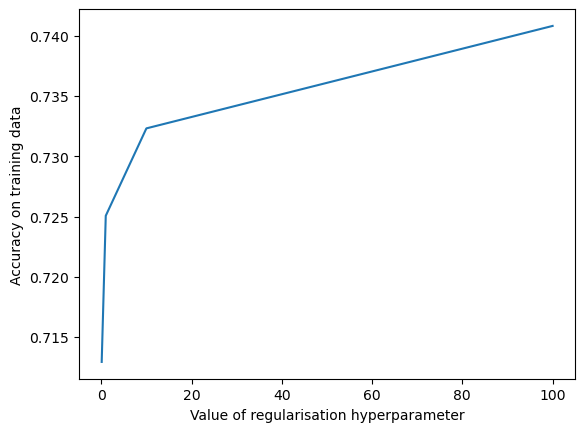

In [21]:
# First we will find the magnitude scale of C, then we will check the values on that magnitude
reg_values = [10**x for x in range(-1,3)]
reg_accuracy = []
for reg_strength in reg_values:
    acc, _ = train_model(SVC, {'C': reg_strength}, X_train, y_train)
    reg_accuracy.append(acc)
    print(str(reg_strength) + "  " + str(acc))
    
# Plotting
plt.plot(reg_values, reg_accuracy)
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of regularisation hyperparameter')
plt.show()

10  0.7323125000000001
30  0.7358125
50  0.738875
70  0.739625
90  0.74075


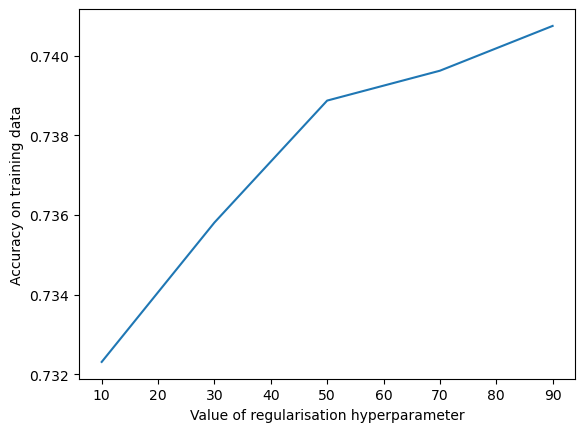

In [35]:
# Now checking between 10 and 100, in increments of 20. Although accuracy increases with
# the regularisation parameter, large values of C lead to overfitting so we restrict
# ourselves to C less than or equal to 100.
reg_values = [10*x for x in range(1,10,2)]
reg_accuracy = []
for reg_strength in reg_values:
    acc, _ = train_model(SVC, {'C': reg_strength}, X_train, y_train)
    reg_accuracy.append(acc)
    print(str(reg_strength) + "  " + str(acc))
    
# Plotting
plt.plot(reg_values, reg_accuracy)
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of regularisation hyperparameter')
plt.show()

### 6.2 Final results with the SVC classifier
Choosing C = 100, in order to increase accuracy without risking overfitting.


Results from algorithm SVC(C=100):
Mean cross-validation accuracy is 0.741 with SD 0.006

Accuracy on training data is 0.746

Accuracy on test data is 0.743


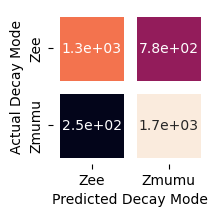


Results from algorithm SVC(C=100):
Mean cross-validation accuracy is 0.753 with SD 0.009

Accuracy on training data is 0.754

Accuracy on test data is 0.746


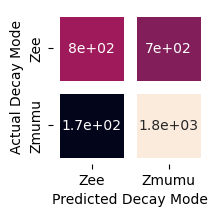

In [23]:
# Calling our train and evaluate function on both DataFrames with C=100
X1 = df.drop(["class_number"], axis=1)
y1 = df["class_number"]

_ = train_and_evaluate(SVC, {"C":100}, X1, y1)

X2 = df2.drop(["class_number"], axis=1)
y2 = df2["class_number"]

_ = train_and_evaluate(SVC, {"C":100}, X2, y2)

### 6.3 Selecting number of neighbours for the K-Neighbors classifier
Using a similar technique to look for the optimal value of the n_neighbors hyperparameter.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

1  0.710875
2  0.6906875
3  0.733
4  0.7199375
5  0.736375
6  0.728375
7  0.7436875
8  0.73525
9  0.7451874999999999
10  0.741125
11  0.7455625
12  0.7461875000000001
13  0.75025
14  0.7484999999999999
15  0.7518125
16  0.748125
17  0.752
18  0.7485625
19  0.7508125000000001
20  0.749875
21  0.750375
22  0.7499374999999999
23  0.7513125
24  0.750375
25  0.7504375
26  0.7490625
27  0.7497499999999999
28  0.7504375000000001
29  0.7501249999999999
30  0.7511875
31  0.750625
32  0.7519375
33  0.7516875
34  0.7525000000000001
35  0.751375
36  0.75275
37  0.7510000000000001
38  0.7513750000000001
39  0.7503125
40  0.750625
41  0.7490625
42  0.7500625000000001
43  0.749
44  0.750625
45  0.74775
46  0.7476875
47  0.7468125
48  0.748
49  0.7471249999999999
50  0.747875
51  0.7467499999999999
52  0.7473750000000001
53  0.7463124999999999
54  0.7471249999999999
55  0.7473124999999999
56  0.7478750000000001
57  0.747625
58  0.7480624999999999
59  0.748
60  0.7484999999999999
61  0.74775
62  0.7475

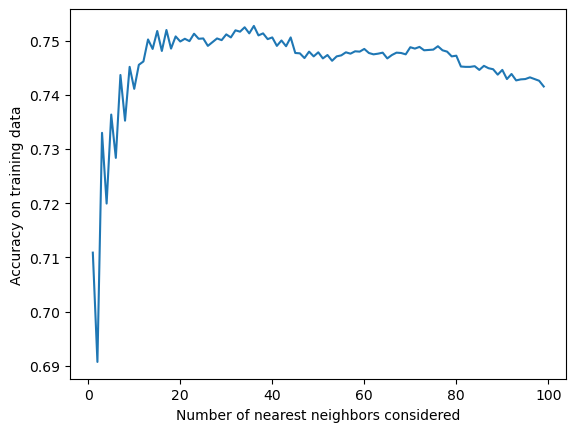

In [25]:
n_values = [x for x in range(1,100)]
n_accuracy = []
for n in n_values:
    acc, _ = train_model(KNeighborsClassifier, {'n_neighbors': n}, X_train, y_train)
    n_accuracy.append(acc)
    print(str(n) + "  " + str(acc))
    
# plotting
plt.plot(n_values, n_accuracy)
plt.ylabel('Accuracy on training data')
plt.xlabel('Number of nearest neighbors considered')
plt.show()

### 6.2 Final results with the K-Neighbors classifier
Choosing n_neighbors = 17 as this is around where the accuracy plateaus.


Results from algorithm KNeighborsClassifier(n_neighbors=17):
Mean cross-validation accuracy is 0.752 with SD 0.006

Accuracy on training data is 0.780

Accuracy on test data is 0.758


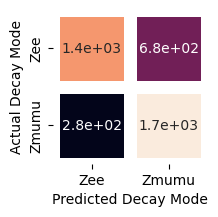


Results from algorithm KNeighborsClassifier(n_neighbors=17):
Mean cross-validation accuracy is 0.753 with SD 0.003

Accuracy on training data is 0.780

Accuracy on test data is 0.748


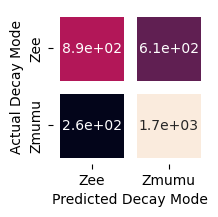

In [26]:
# Calling our train and evaluate function on both DataFrames with n_neighbors = 17
X1 = df.drop(["class_number"], axis=1)
y1 = df["class_number"]

_ = train_and_evaluate(KNeighborsClassifier, {'n_neighbors':17}, X1, y1)

X2 = df2.drop(["class_number"], axis=1)
y2 = df2["class_number"]

_ = train_and_evaluate(KNeighborsClassifier, {'n_neighbors':17}, X2, y2)

## 7 References
Scikit-learn library used for machine learning models:

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, (2011)


Code from Queen Mary University of London's ECS784 Lab 5 Part 1 used throughout.